In [0]:
from google.colab import drive
drive.mount('/content/recommendation_system/')

Drive already mounted at /content/recommendation_system/; to attempt to forcibly remount, call drive.mount("/content/recommendation_system/", force_remount=True).


In [0]:
## http://vision.stanford.edu/aditya86/ImageNetDogs/

In [0]:
# import necessary data management libraries
import numpy as np
import pandas as pd
import os
from random import shuffle
import matplotlib.pyplot as plt
from itertools import count
import itertools

## Import library for image processing
from PIL import Image
from PIL import ImageFilter

#import sklearn library for evalution
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
import sklearn.metrics.pairwise as pw


#import keras for modeling
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import TensorBoard
from keras import regularizers



import random

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8388143721369269727
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17010116555949905286
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17859465764941855103
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10165648600092749719
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
full_path = "/content/recommendation_system/My Drive/Leuphana Projects/Image_Recommendation_System/Images/"

##working params
# IMG_SIZE = 256
# IMG_RESIZE = 256
# NUM_OF_CATEGORY = 30
# NUM_OF_DOGS = 100
IMG_SIZE = 128
IMG_RESIZE = 128
NUM_OF_CATEGORY = 50
NUM_OF_DOGS = 150

In [0]:
def load_data(image_path_dir):
  
  print("Loading Images Started!!!!")
  image_data = []
  
  folder_paths = os.listdir(image_path_dir)

  count = 0

  for folder in folder_paths:

      print(count)
      
      if(count == NUM_OF_CATEGORY):
        break
    
      count = count + 1
      
      num_of_dogs = 0

      full_folder_path = full_path + folder
      
      #print(full_folder_path)

      
      for image_path in os.listdir(full_folder_path):

        full_image_path = full_folder_path + "/" + image_path

        #
        
        if(num_of_dogs == NUM_OF_DOGS):
          break
        num_of_dogs = num_of_dogs + 1

        if(".DS_Store" in full_image_path):
            pass
        else:
            image = Image.open(full_image_path)
            image = image.resize((IMG_SIZE,IMG_SIZE),Image.ANTIALIAS)
            try:                                                    
                image_data.append(image)
            except Exception as e:
                pass
  print("Loading Images Done!!!!")
  return image_data

In [0]:
def reshape_data(images):
    print("Reshaping Images Started!!!!")
    training_data = []
    for img in images:
        training_data.append([np.array(img)])
        
    print("Length of Original Imported Data: {}".format(len(training_data)))
    train_features_reshaped = np.array([i for i in training_data]).reshape(-1, 3 * IMG_RESIZE * IMG_RESIZE)
    train_features_reshaped = train_features_reshaped.astype('float32') / 255.
    
    print("Length of Reshaped Data: {}".format(len(train_features_reshaped)))

    #train_features_reshaped = train_features_reshaped.astype('float32')
    print("Reshaping Images Done!!!!")
    return train_features_reshaped

In [0]:
def reshape_data_convolution(images):
    training_data = []
    for img in images:
        training_data.append([np.array(img)])
    train_features_reshaped = np.array([i for i in training_data]).reshape(-1, IMG_RESIZE, IMG_RESIZE, 3)
    train_features_reshaped = train_features_reshaped.astype('float32') / 255.
    print("Reshaping Finished")
    return train_features_reshaped

In [0]:
def deep_auto_encoder(x_train, epochs):
    
    input_img = Input(shape=(x_train.shape[1],))
    encoded = Dense(128, activation='tanh')(input_img)
    encoded = Dense(64, activation='tanh')(encoded)
    encoded = Dense(32, activation='tanh')(encoded)

    decoded = Dense(64, activation='tanh')(encoded)
    decoded = Dense(128, activation='tanh')(decoded)
    decoded = Dense(x_train.shape[1], activation='sigmoid')(decoded)
    
    feature_extractor_model = Model(input_img, encoded)
    autoencoder = Model(input_img, decoded)
    
    print(autoencoder.summary())
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train, x_train,
                    epochs=epochs,
                    batch_size=50,
                    shuffle=True)
    
    return feature_extractor_model, autoencoder

In [0]:
def deep_auto_encoder_relu(x_train, epochs):
    
    input_img = Input(shape=(x_train.shape[1],))
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(x_train.shape[1], activation='sigmoid')(decoded)
    
    feature_extractor_model = Model(input_img, encoded)
    autoencoder = Model(input_img, decoded)
    
    print(autoencoder.summary())
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train, x_train,
                    epochs=epochs,
                    batch_size=50,
                    shuffle=True)
    
    return feature_extractor_model, autoencoder

In [0]:
def convolutional_deep_autoencoder(x_train, epochs):
    
    input_img = Input(shape=(IMG_RESIZE, IMG_SIZE, 3))
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name="1")(input_img)
    x = MaxPooling2D((2, 2), padding='same',  name="2")(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same',  name="3")(x)
    x = MaxPooling2D((2, 2), padding='same',  name="4")(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same',  name="5")(x)
    encoded = MaxPooling2D((2, 2), padding='same',  name="6")(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same',  name="7")(encoded)
    x = UpSampling2D((2, 2),  name="8")(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same',  name="9")(x)
    x = UpSampling2D((2, 2),  name="10")(x)
    x = Conv2D(16, (1, 1), activation='relu',  name="11")(x)
    x = UpSampling2D((2, 2),  name="12")(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same',  name="13")(x)

    
    feature_extractor_model = Model(input_img, encoded)
    autoencoder = Model(input_img, decoded)
    print(autoencoder.summary())
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=50,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
    
    return feature_extractor_model, autoencoder

In [0]:
!ls

recommendation_system  sample_data


In [0]:
#!tar -xvf /content/recommendation_system/My\ Drive/Leuphana\ Projects/Image_Recommendation_System/Dogimages.tar /content/recommendation_system/My\ Drive/Leuphana\ Projects/Image_Recommendation_System/

In [0]:
!ls

recommendation_system  sample_data


In [0]:
#!tar -xvf /content/recommendation_system/My\ Drive/Leuphana\ Projects/Image_Recommendation_System/Dogimages.tar

In [0]:
!pwd

/content


In [0]:
!cd ..

In [0]:
training_images = load_data(full_path)

Loading Images Started!!!!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Loading Images Done!!!!


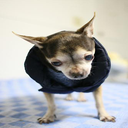

In [0]:
training_images[0]

In [0]:
random.shuffle(training_images)

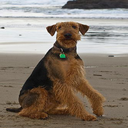

In [0]:
training_images[0]

In [0]:
np.array(training_images[0]).shape

(128, 128, 3)

In [0]:
reshaped_data = reshape_data(training_images)

Reshaping Images Started!!!!
Length of Original Imported Data: 7497
Length of Reshaped Data: 7497
Reshaping Images Done!!!!


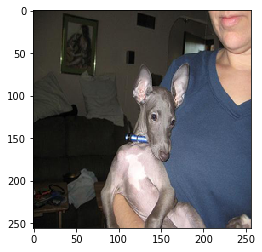

In [0]:
plt.imshow(reshaped_data[0].reshape(IMG_RESIZE, IMG_RESIZE, 3))

# Train with 10 Epochs


In [0]:
feature_extractor_model, auto_encoder_model = deep_auto_encoder(reshaped_data, 10)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 786432)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100663424 
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 786432)            1014

In [0]:
features = feature_extractor_model.predict(reshaped_data)

In [0]:
features.shape

(750, 32)

In [0]:
decoded_features = auto_encoder_model.predict(reshaped_data)

In [0]:
decoded_features.shape

(750, 786432)

In [0]:
recommender = pw.cosine_similarity(features)
recommender_df = pd.DataFrame(recommender)

In [0]:
recommender_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749
0,1.000000,0.813051,0.841313,0.677466,0.809026,0.865738,0.827536,0.893332,0.848091,0.634355,0.819691,0.788838,0.786867,0.800157,0.880992,0.840080,0.787507,0.830869,0.737016,0.666076,0.714896,0.794786,0.799396,0.901162,0.717338,0.760447,0.671663,0.871046,0.860080,0.861406,0.857268,0.759649,0.783264,0.810188,0.712694,0.780642,0.783483,0.681497,0.706035,0.773524,...,0.791420,0.733606,0.889210,0.843274,0.839284,0.885162,0.617226,0.881909,0.751122,0.662837,0.747278,0.836486,0.809058,0.621342,0.832139,0.695364,0.854500,0.724269,0.914387,0.870536,0.824035,0.769565,0.906720,0.905294,0.811138,0.686857,0.829492,0.834605,0.843057,0.781086,0.863020,0.634323,0.748648,0.720360,0.832323,0.805944,0.734681,0.882230,0.886495,0.752898
1,0.813051,1.000000,0.820890,0.649806,0.755119,0.831565,0.772621,0.878800,0.882343,0.507590,0.876464,0.875307,0.824298,0.751982,0.843693,0.892397,0.864099,0.846642,0.627490,0.698444,0.706035,0.909492,0.783884,0.832883,0.760547,0.632153,0.695565,0.869961,0.810455,0.818859,0.748892,0.874023,0.655797,0.763536,0.531766,0.876045,0.887076,0.712574,0.677300,0.624827,...,0.848453,0.596122,0.877751,0.924540,0.804306,0.790263,0.511935,0.922950,0.655880,0.649617,0.806713,0.796381,0.739437,0.528066,0.777615,0.584869,0.864685,0.834209,0.852070,0.846247,0.795560,0.874553,0.922343,0.934426,0.751151,0.674486,0.773062,0.726973,0.732693,0.822360,0.861349,0.568420,0.855137,0.763522,0.891431,0.813115,0.573094,0.873390,0.864546,0.722067
2,0.841313,0.820890,1.000000,0.676924,0.737536,0.806424,0.819192,0.920079,0.839561,0.577245,0.882336,0.795880,0.845305,0.659614,0.851010,0.838847,0.886147,0.866407,0.698626,0.772187,0.675817,0.853488,0.753585,0.758050,0.818559,0.669736,0.666004,0.889442,0.858525,0.843530,0.839760,0.837209,0.736189,0.759592,0.630408,0.890796,0.819846,0.708680,0.597123,0.704401,...,0.895883,0.709614,0.881113,0.812194,0.877160,0.842428,0.573442,0.886057,0.735590,0.573123,0.702612,0.764811,0.771349,0.720361,0.835624,0.694268,0.861183,0.885295,0.826359,0.892515,0.877208,0.798498,0.886082,0.898198,0.867142,0.820928,0.773572,0.868863,0.800290,0.813984,0.864207,0.571231,0.827273,0.783972,0.777634,0.881539,0.690175,0.808677,0.787936,0.699278
3,0.677466,0.649806,0.676924,1.000000,0.853009,0.863994,0.731715,0.652001,0.694539,0.763943,0.627128,0.723233,0.770087,0.523070,0.605317,0.563937,0.754484,0.792161,0.864423,0.643091,0.605642,0.722020,0.619878,0.703069,0.774321,0.882709,0.787447,0.842257,0.633100,0.863405,0.788636,0.639106,0.887423,0.593594,0.714276,0.586913,0.578683,0.706724,0.675527,0.738401,...,0.649240,0.723747,0.733938,0.724724,0.746774,0.863451,0.793806,0.634452,0.834812,0.744844,0.715714,0.831602,0.752800,0.855139,0.817764,0.860504,0.683462,0.545948,0.697441,0.819331,0.628275,0.643378,0.744894,0.708250,0.660693,0.549637,0.770612,0.859664,0.735345,0.664712,0.619374,0.760408,0.809262,0.628885,0.669249,0.665174,0.836561,0.765275,0.816382,0.707616
4,0.809026,0.755119,0.737536,0.853009,1.000000,0.951219,0.753327,0.827473,0.769323,0.781527,0.784242,0.810611,0.735893,0.688034,0.754386,0.702445,0.829011,0.904154,0.939665,0.668902,0.662968,0.797462,0.602837,0.835908,0.742370,0.904511,0.829507,0.852350,0.671598,0.921960,0.826174,0.680262,0.907913,0.728663,0.846790,0.739616,0.663413,0.644936,0.686543,0.835053,...,0.748219,0.852302,0.787951,0.850666,0.755368,0.926481,0.822341,0.776075,0.911830,0.732592,0.837524,0.923994,0.880776,0.809766,0.862176,0.817218,0.800360,0.538477,0.877770,0.821124,0.690713,0.734316,0.874773,0.792004,0.639092,0.533940,0.882285,0.842631,0.867448,0.710200,0.750444,0.828143,0.857302,0.577957,0.735402,0.707884,0.872403,0.895716,0.850315,0.747010


In [0]:
def recommend_top_n_elements(index, n, recommender_df):
  print(np.sort(recommender_df.iloc[index,])[::-1][:n])
  return np.argsort(recommender_df.iloc[index,])[::-1][:n]

In [0]:
recommended_images = recommend_top_n_elements(14, 5)
recommended_images_indices = recommended_images.values


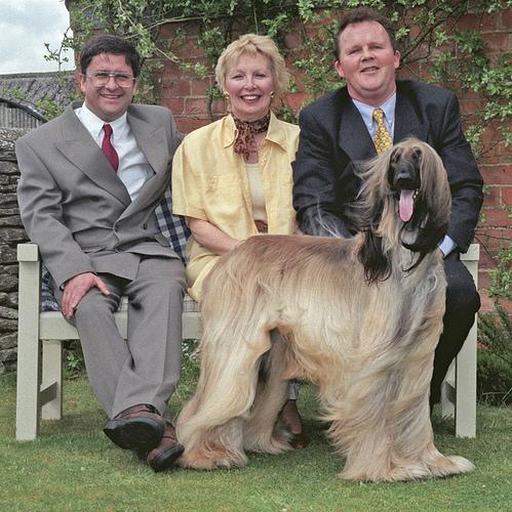

In [0]:
training_images[14]

In [0]:
recommender_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749
0,1.000000,0.813051,0.841313,0.677466,0.809026,0.865738,0.827536,0.893332,0.848091,0.634355,0.819691,0.788838,0.786867,0.800157,0.880992,0.840080,0.787507,0.830869,0.737016,0.666076,0.714896,0.794786,0.799396,0.901162,0.717338,0.760447,0.671663,0.871046,0.860080,0.861406,0.857268,0.759649,0.783264,0.810188,0.712694,0.780642,0.783483,0.681497,0.706035,0.773524,...,0.791420,0.733606,0.889210,0.843274,0.839284,0.885162,0.617226,0.881909,0.751122,0.662837,0.747278,0.836486,0.809058,0.621342,0.832139,0.695364,0.854500,0.724269,0.914387,0.870536,0.824035,0.769565,0.906720,0.905294,0.811138,0.686857,0.829492,0.834605,0.843057,0.781086,0.863020,0.634323,0.748648,0.720360,0.832323,0.805944,0.734681,0.882230,0.886495,0.752898
1,0.813051,1.000000,0.820890,0.649806,0.755119,0.831565,0.772621,0.878800,0.882343,0.507590,0.876464,0.875307,0.824298,0.751982,0.843693,0.892397,0.864099,0.846642,0.627490,0.698444,0.706035,0.909492,0.783884,0.832883,0.760547,0.632153,0.695565,0.869961,0.810455,0.818859,0.748892,0.874023,0.655797,0.763536,0.531766,0.876045,0.887076,0.712574,0.677300,0.624827,...,0.848453,0.596122,0.877751,0.924540,0.804306,0.790263,0.511935,0.922950,0.655880,0.649617,0.806713,0.796381,0.739437,0.528066,0.777615,0.584869,0.864685,0.834209,0.852070,0.846247,0.795560,0.874553,0.922343,0.934426,0.751151,0.674486,0.773062,0.726973,0.732693,0.822360,0.861349,0.568420,0.855137,0.763522,0.891431,0.813115,0.573094,0.873390,0.864546,0.722067
2,0.841313,0.820890,1.000000,0.676924,0.737536,0.806424,0.819192,0.920079,0.839561,0.577245,0.882336,0.795880,0.845305,0.659614,0.851010,0.838847,0.886147,0.866407,0.698626,0.772187,0.675817,0.853488,0.753585,0.758050,0.818559,0.669736,0.666004,0.889442,0.858525,0.843530,0.839760,0.837209,0.736189,0.759592,0.630408,0.890796,0.819846,0.708680,0.597123,0.704401,...,0.895883,0.709614,0.881113,0.812194,0.877160,0.842428,0.573442,0.886057,0.735590,0.573123,0.702612,0.764811,0.771349,0.720361,0.835624,0.694268,0.861183,0.885295,0.826359,0.892515,0.877208,0.798498,0.886082,0.898198,0.867142,0.820928,0.773572,0.868863,0.800290,0.813984,0.864207,0.571231,0.827273,0.783972,0.777634,0.881539,0.690175,0.808677,0.787936,0.699278
3,0.677466,0.649806,0.676924,1.000000,0.853009,0.863994,0.731715,0.652001,0.694539,0.763943,0.627128,0.723233,0.770087,0.523070,0.605317,0.563937,0.754484,0.792161,0.864423,0.643091,0.605642,0.722020,0.619878,0.703069,0.774321,0.882709,0.787447,0.842257,0.633100,0.863405,0.788636,0.639106,0.887423,0.593594,0.714276,0.586913,0.578683,0.706724,0.675527,0.738401,...,0.649240,0.723747,0.733938,0.724724,0.746774,0.863451,0.793806,0.634452,0.834812,0.744844,0.715714,0.831602,0.752800,0.855139,0.817764,0.860504,0.683462,0.545948,0.697441,0.819331,0.628275,0.643378,0.744894,0.708250,0.660693,0.549637,0.770612,0.859664,0.735345,0.664712,0.619374,0.760408,0.809262,0.628885,0.669249,0.665174,0.836561,0.765275,0.816382,0.707616
4,0.809026,0.755119,0.737536,0.853009,1.000000,0.951219,0.753327,0.827473,0.769323,0.781527,0.784242,0.810611,0.735893,0.688034,0.754386,0.702445,0.829011,0.904154,0.939665,0.668902,0.662968,0.797462,0.602837,0.835908,0.742370,0.904511,0.829507,0.852350,0.671598,0.921960,0.826174,0.680262,0.907913,0.728663,0.846790,0.739616,0.663413,0.644936,0.686543,0.835053,...,0.748219,0.852302,0.787951,0.850666,0.755368,0.926481,0.822341,0.776075,0.911830,0.732592,0.837524,0.923994,0.880776,0.809766,0.862176,0.817218,0.800360,0.538477,0.877770,0.821124,0.690713,0.734316,0.874773,0.792004,0.639092,0.533940,0.882285,0.842631,0.867448,0.710200,0.750444,0.828143,0.857302,0.577957,0.735402,0.707884,0.872403,0.895716,0.850315,0.747010


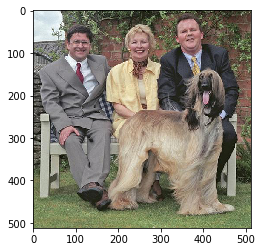

In [0]:
plt.imshow(reshaped_data[14].reshape(IMG_RESIZE, IMG_RESIZE, 3))

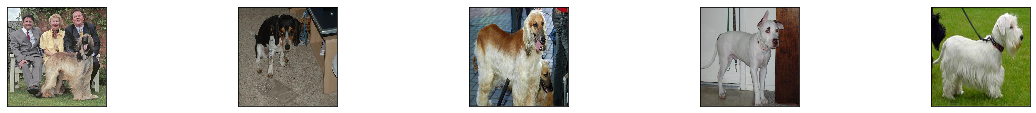

In [0]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(reshaped_data[recommended_images_indices[i]].reshape(IMG_RESIZE, IMG_RESIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Train with 100 epochs

In [0]:
feature_extractor_model, auto_encoder_model = deep_auto_encoder(reshaped_data, 100)




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 196608)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25165952  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 196608)            2

In [0]:
decoded_features = auto_encoder_model.predict(reshaped_data)

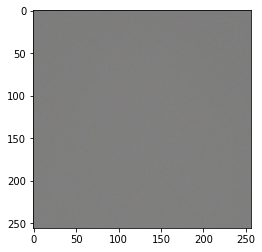

In [0]:
plt.imshow(decoded_features[40].reshape(IMG_RESIZE, IMG_RESIZE, 3))

In [0]:
features = feature_extractor_model.predict(reshaped_data)
recommender = pw.cosine_similarity(features)
recommender_df = pd.DataFrame(recommender)

In [0]:
recommender_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749
0,1.000000,-0.590208,0.787052,0.635596,-0.478738,0.763147,-0.554874,0.810229,0.839706,-0.549281,-0.530315,0.926624,-0.359631,-0.531158,-0.505284,0.934925,0.640891,-0.157559,-0.581766,-0.540610,-0.515902,0.290975,0.757133,-0.659828,0.719625,-0.549442,0.929255,-0.476437,-0.549754,-0.546225,-0.467047,-0.510946,-0.528439,-0.561835,-0.658833,-0.560435,-0.659025,0.543322,0.950336,-0.309604,...,0.794670,-0.686369,0.785260,0.952990,-0.596391,-0.620069,0.744234,0.841073,-0.596539,-0.468023,0.695649,-0.560749,0.869347,-0.591186,-0.637700,-0.485031,-0.170429,0.398868,0.747380,0.854336,-0.565120,-0.504973,-0.158691,-0.553891,-0.025077,0.760155,-0.648739,-0.520584,-0.590351,-0.482400,-0.514063,-0.525308,0.701818,0.912589,-0.608707,-0.468457,-0.204127,-0.521941,0.801703,-0.707724
1,-0.590208,1.000000,-0.936033,-0.971512,0.978568,-0.954038,0.988808,-0.913899,-0.892888,0.995883,0.990605,-0.631361,0.941804,0.991516,0.985689,-0.786998,-0.728420,0.823275,0.958983,0.991993,0.987357,0.481723,-0.937823,0.986104,-0.942498,0.995556,-0.521719,0.973230,0.993032,0.993860,0.977714,0.978646,0.991031,0.988527,0.984369,0.995559,0.983309,-0.929493,-0.756494,0.908822,...,-0.923109,0.980535,-0.922673,-0.587739,0.996255,0.995371,-0.947661,-0.893962,0.990861,0.973487,0.064882,0.996079,-0.265984,0.998116,0.995741,0.984685,0.838692,0.392849,-0.053830,-0.708293,0.996693,0.985338,0.833693,0.995378,0.762338,-0.333273,0.992629,0.989197,0.996638,0.978036,0.989316,0.993149,-0.952839,-0.724593,0.997060,0.975593,0.854614,0.973639,-0.920509,0.972149
2,0.787052,-0.936033,1.000000,0.962406,-0.887245,0.986678,-0.911262,0.985650,0.985772,-0.919007,-0.910225,0.825024,-0.818959,-0.915716,-0.898549,0.931513,0.801489,-0.654679,-0.907461,-0.907537,-0.903108,-0.244218,0.973571,-0.956547,0.960320,-0.918781,0.748388,-0.879065,-0.912041,-0.916309,-0.879056,-0.898127,-0.911114,-0.926786,-0.955579,-0.924194,-0.950178,0.904727,0.900659,-0.777274,...,0.972858,-0.951687,0.974477,0.790470,-0.937539,-0.948858,0.990831,0.974129,-0.934940,-0.878784,0.193969,-0.923418,0.528013,-0.938420,-0.950294,-0.889561,-0.676391,-0.146443,0.315765,0.826715,-0.926926,-0.896960,-0.677273,-0.923175,-0.563847,0.522884,-0.950413,-0.905679,-0.939129,-0.884035,-0.902350,-0.914392,0.977086,0.881969,-0.942649,-0.873035,-0.696297,-0.893428,0.991502,-0.953198
3,0.635596,-0.971512,0.962406,1.000000,-0.959180,0.966459,-0.965795,0.939949,0.919174,-0.969933,-0.969039,0.674787,-0.919972,-0.972040,-0.963700,0.820875,0.790511,-0.757711,-0.921463,-0.962911,-0.964771,-0.428809,0.965625,-0.965679,0.973369,-0.970868,0.575468,-0.948788,-0.962591,-0.970067,-0.953795,-0.965703,-0.964837,-0.978682,-0.964339,-0.967616,-0.961107,0.961428,0.781915,-0.891196,...,0.932748,-0.952152,0.953506,0.625888,-0.967723,-0.975263,0.978940,0.910941,-0.968431,-0.955598,-0.016018,-0.973018,0.337966,-0.974662,-0.969053,-0.957966,-0.800585,-0.338787,0.133599,0.739183,-0.973800,-0.960875,-0.805530,-0.972695,-0.696323,0.386851,-0.964389,-0.965005,-0.978790,-0.957258,-0.965139,-0.967855,0.989219,0.757404,-0.974006,-0.948937,-0.825992,-0.950822,0.945794,-0.943855
4,-0.478738,0.978568,-0.887245,-0.959180,1.000000,-0.908902,0.983256,-0.865240,-0.832114,0.988653,0.989551,-0.526233,0.981521,0.993512,0.996270,-0.698460,-0.700552,0.880813,0.928082,0.987788,0.995268,0.601754,-0.901184,0.947025,-0.913589,0.989148,-0.414036,0.993866,0.982785,0.988674,0.997472,0.977642,0.991437,0.979405,0.946852,0.988463,0.936964,-0.936199,-0.660381,0.967321,...,-0.876436,0.930953,-0.879545,-0.483976,0.977595,0.964536,-0.908082,-0.829280,0.970138,0.997791,0.199074,0.987657,-0.143060,0.978138,0.961012,0.996931,0.898204,0.520446,0.061176,-0.622262,0.986673,0.994953,0.909471,0.987488,0.836523,-0.261816,0.954932,0.9943

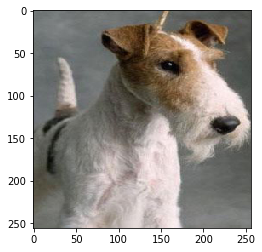

In [0]:
plt.imshow(reshaped_data[40].reshape(IMG_RESIZE, IMG_RESIZE, 3))

In [0]:
recommended_images = recommend_top_n_elements(40, 5)
recommended_images_indices = recommended_images.values

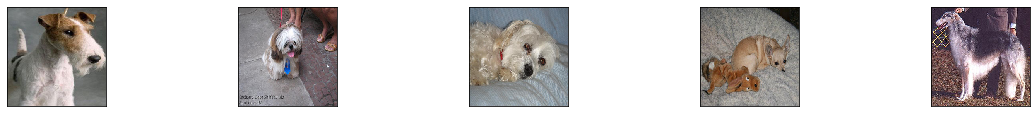

In [0]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(reshaped_data[recommended_images_indices[i]].reshape(IMG_RESIZE, IMG_RESIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
feature_extractor_model, auto_encoder_model = deep_auto_encoder_relu(reshaped_data, 100)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 196608)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               25165952  
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 196608)            2536

In [0]:
decoded_features = auto_encoder_model.predict(reshaped_data)

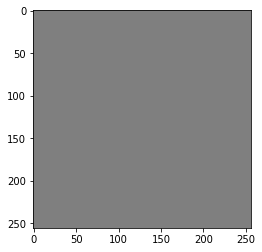

In [0]:
plt.imshow(decoded_features[3].reshape(IMG_RESIZE, IMG_RESIZE, 3))

# CNN Training

In [0]:
reshaped_data_cnn = reshape_data_convolution(training_images)

Reshaping Finished


In [0]:
cnn_feature_extractor_model, cnn_auto_encoder_model = convolutional_deep_autoencoder(reshaped_data_cnn, 10)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
1 (Conv2D)                   (None, 256, 256, 16)      448       
_________________________________________________________________
2 (MaxPooling2D)             (None, 128, 128, 16)      0         
_________________________________________________________________
3 (Conv2D)                   (None, 128, 128, 8)       1160      
_________________________________________________________________
4 (MaxPooling2D)             (None, 64, 64, 8)         0         
_________________________________________________________________
5 (Conv2D)                   (None, 64, 64, 8)         584       
_________________________________________________________________
6 (MaxPooling2D)             (None, 32, 32, 8)         0  

In [0]:
decode_features_cnn = cnn_auto_encoder_model.predict(reshaped_data_cnn)

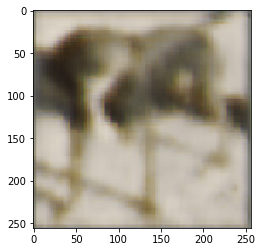

In [0]:
plt.imshow(decode_features_cnn[10].reshape(IMG_RESIZE, IMG_RESIZE, 3))

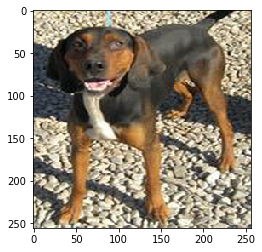

In [0]:
plt.imshow(reshaped_data_cnn[10].reshape(IMG_RESIZE, IMG_RESIZE, 3))

# Train with 100 epochs

In [0]:
cnn_feature_extractor_model, cnn_auto_encoder_model = convolutional_deep_autoencoder(reshaped_data_cnn, 100)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
1 (Conv2D)                   (None, 256, 256, 16)      448       
_________________________________________________________________
2 (MaxPooling2D)             (None, 128, 128, 16)      0         
_________________________________________________________________
3 (Conv2D)                   (None, 128, 128, 8)       1160      
_________________________________________________________________
4 (MaxPooling2D)             (None, 64, 64, 8)         0         
_________________________________________________________________
5 (Conv2D)                   (None, 64, 64, 8)         584       
_________________________________________________________________
6 (MaxPooling2D)             (None, 32, 32, 8)         0  

In [0]:
decode_features_cnn = cnn_auto_encoder_model.predict(reshaped_data_cnn)

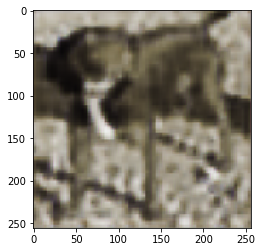

In [0]:
plt.imshow(decode_features_cnn[10].reshape(IMG_RESIZE, IMG_RESIZE, 3))

# With More Training Data and More Epochs

In [0]:
cnn_feature_extractor_model, cnn_auto_encoder_model = convolutional_deep_autoencoder(
    reshaped_data_cnn, 200)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
1 (Conv2D)                   (None, 256, 256, 16)      448       
_________________________________________________________________
2 (MaxPooling2D)             (None, 128, 128, 16)      0         
_________________________________________________________________
3 (Conv2D)                   (None, 128, 128, 8)       1160      
_________________________________________________________________
4 (MaxPooling2D)             (None, 64, 64, 8)         0         
_________________________________________________________________
5 (Conv2D)                   (None, 64, 64, 8)         584       
_________________________________________________________________
6 (MaxPooling2D)             (None, 32, 32, 8)         0  

In [0]:
decode_features_cnn = cnn_auto_encoder_model.predict(reshaped_data_cnn)

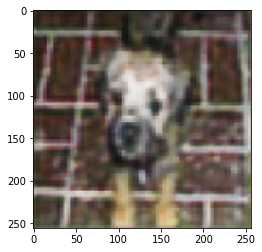

In [0]:
plt.imshow(decode_features_cnn[10].reshape(IMG_RESIZE, IMG_RESIZE, 3))

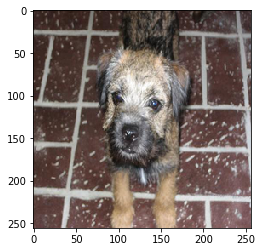

In [0]:
plt.imshow(reshaped_data_cnn[10].reshape(IMG_RESIZE, IMG_RESIZE, 3))

In [0]:
features_extracted = cnn_feature_extractor_model.predict(reshaped_data_cnn)

In [0]:
cnn_features_extracted = np.array([i for i in features_extracted]).reshape(-1, 8 * 32 * 32)

In [0]:
recommender_cnn = pw.cosine_similarity(cnn_features_extracted)
recommender_cnn_df = pd.DataFrame(recommender_cnn)

In [0]:
recommender_cnn_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,1.000000,0.454383,0.470231,0.402745,0.668783,0.480630,0.493174,0.627471,0.523065,0.472988,0.619951,0.566882,0.441906,0.599239,0.481590,0.656063,0.556558,0.548057,0.501314,0.535003,0.516014,0.663631,0.559602,0.516521,0.517496,0.526422,0.334258,0.548057,0.301033,0.465726,0.618266,0.438289,0.412528,0.487082,0.492449,0.466601,0.391890,0.627927,0.514507,0.572459,...,0.533149,0.415265,0.584764,0.444056,0.693132,0.323693,0.616102,0.507108,0.459689,0.567112,0.360123,0.417937,0.616838,0.462667,0.467390,0.535338,0.472057,0.548774,0.462661,0.441062,0.599299,0.660190,0.520984,0.616718,0.531353,0.500172,0.623600,0.525646,0.519713,0.528776,0.637864,0.620386,0.566726,0.560392,0.519889,0.598075,0.548568,0.577034,0.499867,0.408464
1,0.454383,1.000001,0.396696,0.463432,0.489348,0.346272,0.652160,0.382410,0.421275,0.384920,0.457923,0.448792,0.581846,0.453354,0.494854,0.470482,0.492944,0.430650,0.594058,0.472368,0.348224,0.513114,0.412250,0.490205,0.387553,0.484777,0.445922,0.352176,0.517710,0.631104,0.436706,0.510129,0.415990,0.456905,0.368660,0.361359,0.600720,0.355542,0.455141,0.526885,...,0.511462,0.503683,0.457123,0.484052,0.492815,0.569711,0.330909,0.345606,0.606813,0.389526,0.612661,0.480623,0.369049,0.392532,0.596423,0.402051,0.455973,0.528912,0.507131,0.440276,0.408647,0.429310,0.621536,0.448055,0.340690,0.472284,0.494248,0.465565,0.405960,0.424930,0.388570,0.512511,0.502171,0.370285,0.529889,0.412873,0.341165,0.374192,0.597052,0.346617
2,0.470231,0.396696,1.000000,0.564764,0.556678,0.598467,0.410119,0.607129,0.606725,0.665808,0.658205,0.552241,0.466488,0.644248,0.501194,0.494701,0.334973,0.599090,0.550017,0.616874,0.671435,0.608524,0.576105,0.617157,0.599176,0.673889,0.352226,0.553811,0.376225,0.472927,0.483534,0.427128,0.442683,0.366625,0.677384,0.660290,0.328233,0.470733,0.663791,0.633530,...,0.535836,0.658755,0.605577,0.534351,0.584521,0.431741,0.634972,0.601465,0.527289,0.576221,0.379735,0.534739,0.632215,0.616580,0.456982,0.639492,0.580730,0.478419,0.425492,0.550383,0.574602,0.602890,0.461814,0.543282,0.625644,0.607495,0.500306,0.354638,0.598702,0.646285,0.625140,0.499567,0.575280,0.686241,0.487270,0.590681,0.646385,0.597711,0.469680,0.653191
3,0.402745,0.463432,0.564764,1.000000,0.508882,0.438772,0.431660,0.414703,0.573989,0.654123,0.595436,0.563438,0.459824,0.610151,0.557181,0.462961,0.310230,0.577486,0.536983,0.548929,0.573459,0.528103,0.531233,0.579940,0.587240,0.591499,0.483675,0.515461,0.524361,0.628725,0.439244,0.505719,0.637188,0.382374,0.566542,0.535785,0.432093,0.417928,0.623331,0.510562,...,0.626970,0.634597,0.555598,0.625082,0.470454,0.597462,0.545980,0.604768,0.534009,0.525123,0.531682,0.477776,0.574915,0.623931,0.559782,0.602531,0.514929,0.511609,0.508789,0.680074,0.507367,0.512807,0.631851,0.471460,0.440556,0.589846,0.518630,0.456489,0.648992,0.652332,0.464375,0.630031,0.556873,0.622541,0.566108,0.523127,0.526648,0.444595,0.514655,0.679298
4,0.668783,0.489348,0.556678,0.508882,1.000000,0.478671,0.508251,0.578505,0.596467,0.487778,0.711577,0.620054,0.514621,0.636444,0.693174,0.696082,0.539640,0.646585,0.437687,0.563047,0.513742,0.713114,0.479074,0.689740,0.531779,0.606420,0.461784,0.509038,0.425666,0.662734,0.721806,0.616306,0.433208,0.503247,0.494999,0.479533,0.462522,0.600112,0.688994,0.550450,...,0.596198,0.570271,0.650897,0.554801,0.730212,0.350936,0.609905,0.458590,0.522303,0.664975,0.383972,0.589209,0.624967,0.506218,0.598719,0.611395,0.503150,0.728697,0.494364,0.578028,0.703439,0.786946,0.628985,0.647716,0.563328,0.568082,0.599821,0.568614,0.599143,0.585667,0.653688,0.690409,0.705941,0.582847,0.571895,0.545357,0.560714,0.605159,0.612272,0.421557


In [0]:
recommended_images_cnn = recommend_top_n_elements(1, 5, recommender_cnn_df)
recommended_images_indices_cnn = recommended_images_cnn.values

[1.0000006  0.7339597  0.73043305 0.726821   0.7211297 ]


In [0]:
recommended_images_indices_cnn

array([   1, 1486, 1599,  754, 1546])

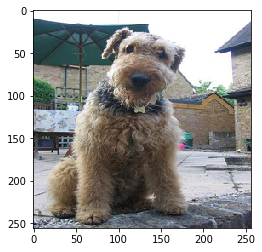

In [0]:
plt.imshow(reshaped_data_cnn[1].reshape(IMG_RESIZE, IMG_RESIZE, 3))

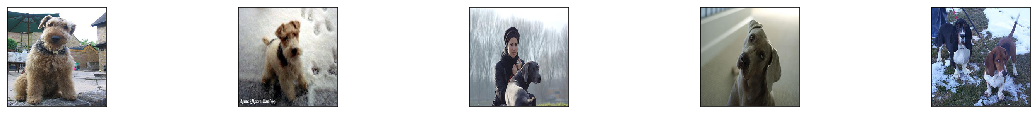

In [0]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(reshaped_data_cnn[recommended_images_indices_cnn[i]].reshape(IMG_RESIZE, IMG_RESIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# WIth Image Resolution Decreased and Epochs increased

In [0]:
cnn_feature_extractor_model, cnn_auto_encoder_model = convolutional_deep_autoencoder(
    reshaped_data_cnn, 300)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
1 (Conv2D)                   (None, 128, 128, 16)      448       
_________________________________________________________________
2 (MaxPooling2D)             (None, 64, 64, 16)        0         
_________________________________________________________________
3 (Conv2D)                   (None, 64, 64, 8)         1160      
_________________________________________________________________
4 (MaxPooling2D)             (None, 32, 32, 8)         0         
_________________________________________________________________
5 (Conv2D)                   (None, 32, 32, 8)         584       
_________________________________________________________________
6 (MaxPooling2D)             (None, 16, 16, 8)         0  

In [0]:
decode_features_cnn = cnn_auto_encoder_model.predict(reshaped_data_cnn)

features_extracted = cnn_feature_extractor_model.predict(reshaped_data_cnn)

cnn_features_extracted = np.array([i for i in features_extracted]).reshape(-1, 8 * 16 * 16)

recommender_cnn = pw.cosine_similarity(cnn_features_extracted)
recommender_cnn_df = pd.DataFrame(recommender_cnn)

print(recommender_cnn_df.head())

       0         1         2     ...      7494      7495      7496
0  1.000000  0.749300  0.680299  ...  0.704534  0.771073  0.481352
1  0.749300  1.000000  0.696213  ...  0.722879  0.781472  0.619984
2  0.680299  0.696213  1.000000  ...  0.680165  0.751674  0.536415
3  0.686825  0.701479  0.712732  ...  0.681112  0.702682  0.534974
4  0.794108  0.765300  0.692376  ...  0.698562  0.733923  0.483059

[5 rows x 7497 columns]


[0.99999964 0.8426136  0.83763415 0.8355655  0.83395565]


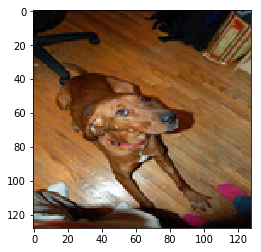

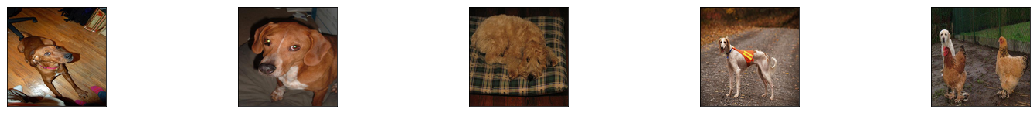

In [0]:
index = 15

plt.imshow(decode_features_cnn[index].reshape(IMG_RESIZE, IMG_RESIZE, 3))

plt.imshow(reshaped_data_cnn[index].reshape(IMG_RESIZE, IMG_RESIZE, 3))

recommended_images_cnn = recommend_top_n_elements(index, 5, recommender_cnn_df)
recommended_images_indices_cnn = recommended_images_cnn.values

n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(reshaped_data_cnn[recommended_images_indices_cnn[i]].reshape(IMG_RESIZE, IMG_RESIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Euclidean Distance Metric

In [0]:
recommender_cnn_ed = pw.euclidean_distances(cnn_features_extracted)
recommender_cnn_ed_df = pd.DataFrame(recommender_cnn_ed)

In [0]:
def get_top_n_recommendations_from_euclidean_distance(index, n, recommender_cnn_ed_df):
  return np.argsort(recommender_cnn_ed_df.iloc[index, ])[:n]

In [0]:
index = 15
recommended_images_indices_cnn_euclidean = get_top_n_recommendations_from_euclidean_distance(15, 5,recommender_cnn_ed_df)
recommended_images_indices_cnn_euclidean = recommended_images_indices_cnn_euclidean.values

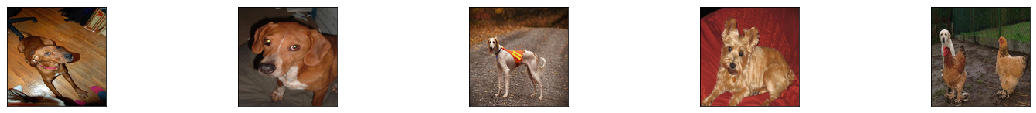

In [0]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(reshaped_data_cnn[recommended_images_indices_cnn_euclidean[i]].reshape(IMG_RESIZE, IMG_RESIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()